In [6]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import time
import random

import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam

from torchvision import transforms, datasets
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from timeit import default_timer as timer
from typing import Dict, List

In [7]:
# access the dataset directory
dataset_dir = Path("../dataset/New Plant Diseases Dataset(Augmented)")

print(dataset_dir)

..\dataset\New Plant Diseases Dataset(Augmented)


In [11]:
# access train and validation directory
train_dir = dataset_dir / "train"
val_dir = dataset_dir / "valid"

print(f"Train Directory : {train_dir}")
print(f"Validation Directory : {val_dir}")
print(f"Test Directory : {test_dir}")

Train Directory : ..\dataset\New Plant Diseases Dataset(Augmented)\train
Validation Directory : ..\dataset\New Plant Diseases Dataset(Augmented)\valid
Test Directory : \dataset\new-plant-diseases-dataset\test


In [14]:
total_class_train = len(os.listdir(train_dir))
total_class_val = len(os.listdir(val_dir))

print(f"Total of Train Data Classes: {total_class_train} classes")
print(f"Total of Validation Data Classes: {total_class_val} classes")

Total of Train Data Classes: 38 classes
Total of Validation Data Classes: 38 classes


In [15]:
# display data distribution
def count_data_per_class(path):
    classes = sorted(os.listdir(path))
    class_counts = {}
    for cls in classes:
        class_path = os.path.join(path, cls)
        class_counts[cls] = len(os.listdir(class_path))
    return class_counts

# calculate total data of each class
train_class_counts = count_data_per_class(train_dir)
val_class_counts = count_data_per_class(val_dir)

# create dataframe class count
train_counts_df = pd.DataFrame.from_dict(train_class_counts, orient="index", columns=["Count"])
val_counts_df = pd.DataFrame.from_dict(val_class_counts, orient="index", columns=["Count"])

In [16]:
# total image for training and validation

print(f"Total Image for Training: {sum(train_class_counts.values())} images")
print(f"Total Image for Validation: {sum(val_class_counts.values())} images")

Total Image for Training: 140590 images
Total Image for Validation: 35144 images


In [17]:
train_counts_df

Count
Apple___Apple_scab                                   4032
Apple___Black_rot                                    3974
Apple___Cedar_apple_rust                             3520
Apple___healthy                                      4016
Blueberry___healthy                                  3632
Cherry_(including_sour)___Powdery_mildew             3366
Cherry_(including_sour)___healthy                    3652
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot   3284
Corn_(maize)___Common_rust_                          3814
Corn_(maize)___Northern_Leaf_Blight                  3816
Corn_(maize)___healthy                               3718
Grape___Black_rot                                    3776
Grape___Esca_(Black_Measles)                         3840
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)           3444
Grape___healthy                                      3384
Orange___Haunglongbing_(Citrus_greening)             4020
Peach___Bacterial_spot                               3676
Peach___healthy                                      3456
Pepper,_bell___Bacterial_spot                        3826
Pepper,_bell___healthy                               3976
Potato___Early_blight                                3878
Potato___Late_blight                                 3878
Potato___healthy                                     3648
Raspberry___healthy                                  3562
Soybean___healthy                                    4044
Squash___Powdery_mildew                              3472
Strawberry___Leaf_scorch                             3548
Strawberry___healthy                                 3648
Tomato___Bacterial_spot                              3404
Tomato___Early_blight                                3840
Tomato___Late_blight                                 3702
Tomato___Leaf_Mold                                   3764
Tomato___Septoria_leaf_spot                          3490
Tomato___Spider_mites Two-spotted_spider_mite        3482
Tomato___Target_Spot                                 3654
Tomato___Tomato_Yellow_Leaf_Curl_Virus               3922
Tomato___Tomato_mosaic_virus                         3580
Tomato___healthy                                     3852

In [18]:
val_counts_df

Count
Apple___Apple_scab                                   1008
Apple___Black_rot                                     994
Apple___Cedar_apple_rust                              880
Apple___healthy                                      1004
Blueberry___healthy                                   908
Cherry_(including_sour)___Powdery_mildew              842
Cherry_(including_sour)___healthy                     912
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot    820
Corn_(maize)___Common_rust_                           954
Corn_(maize)___Northern_Leaf_Blight                   954
Corn_(maize)___healthy                                930
Grape___Black_rot                                     944
Grape___Esca_(Black_Measles)                          960
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)            860
Grape___healthy                                       846
Orange___Haunglongbing_(Citrus_greening)             1006
Peach___Bacterial_spot                                918
Peach___healthy                                       864
Pepper,_bell___Bacterial_spot                         956
Pepper,_bell___healthy                                994
Potato___Early_blight                                 970
Potato___Late_blight                                  970
Potato___healthy                                      912
Raspberry___healthy                                   890
Soybean___healthy                                    1010
Squash___Powdery_mildew                               868
Strawberry___Leaf_scorch                              888
Strawberry___healthy                                  912
Tomato___Bacterial_spot                               850
Tomato___Early_blight                                 960
Tomato___Late_blight                                  926
Tomato___Leaf_Mold                                    940
Tomato___Septoria_leaf_spot                           872
Tomato___Spider_mites Two-spotted_spider_mite         870
Tomato___Target_Spot                                  914
Tomato___Tomato_Yellow_Leaf_Curl_Virus                980
Tomato___Tomato_mosaic_virus                          896
Tomato___healthy                                      962

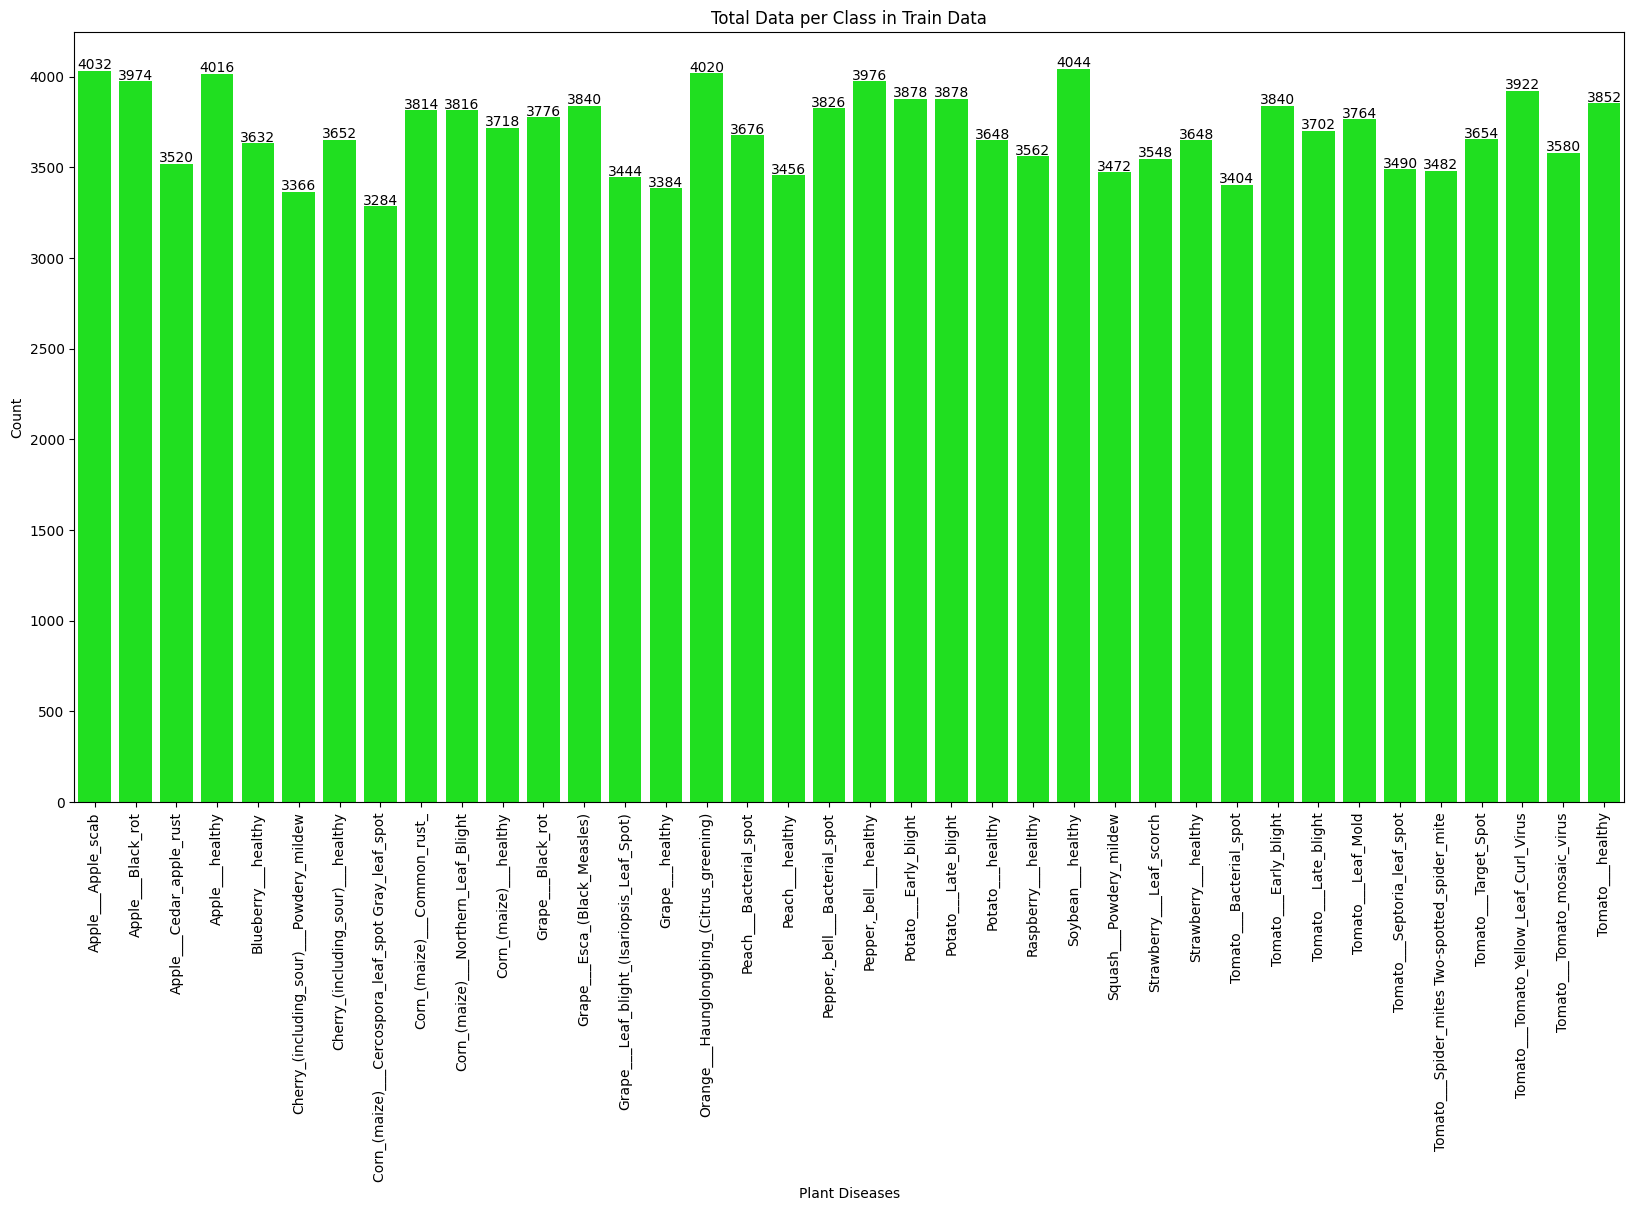

In [19]:
# display barplot for train data
plt.figure(figsize=(20, 10))
sns.barplot(data=train_counts_df, x=train_counts_df.index, y="Count", color="lime")
plt.title("Total Data per Class in Train Data")
plt.xlabel("Plant Diseases")
plt.ylabel("Count")
plt.xticks(rotation=90)

# get the current axes to make the number label on top each bar
ax = plt.gca()

# add count labels on top of each bar
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., # the count label position is center of each bar (x-coordinate)
            p.get_height()+10, # the count label offset of each bar (y-coordinate)
            '{:1.0f}'.format(p.get_height()), # get number of each bar height as count label
            ha="center") # the orientation of count label text is center horizontal

# saving plot
plt.savefig("Total Data per Class in Train Data.jpg")

# show the plot
plt.show()

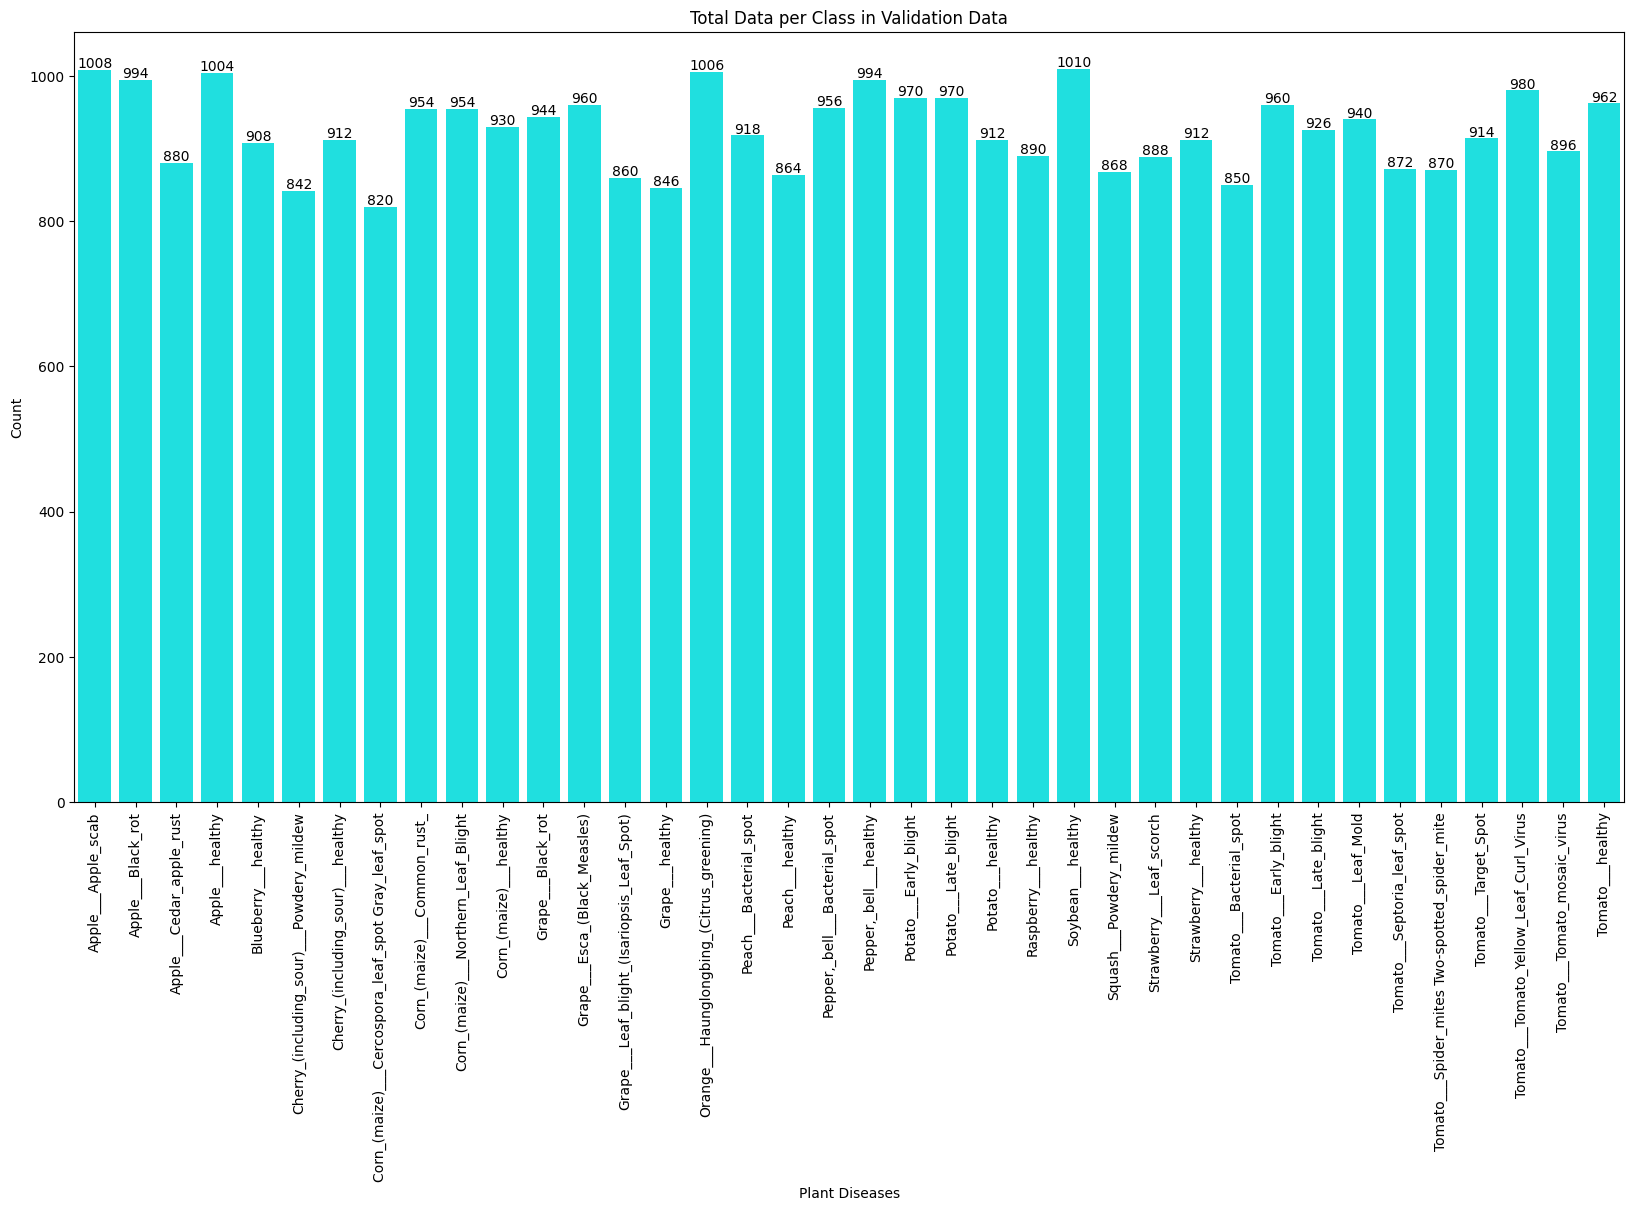

In [20]:
# display barplot for validation data
plt.figure(figsize=(20, 10))
sns.barplot(data=val_counts_df, x=val_counts_df.index, y="Count", color="cyan")
plt.title("Total Data per Class in Validation Data")
plt.xlabel("Plant Diseases")
plt.ylabel("Count")
plt.xticks(rotation=90)

# get the current axes to make the number label on top each bar
ax = plt.gca()

# add count labels on top of each bar
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., # the count label position is center of each bar (x-coordinate)
            p.get_height()+3, # the count label offset of each bar (y-coordinate)
            '{:1.0f}'.format(p.get_height()), # get number of each bar height as count label
            ha="center") # the orientation of count label text is center horizontal

# saving plot
plt.savefig("Total Data per Class in Validation Data.jpg")

# show the plot
plt.show()


In [21]:
# display plant types and diseases
all_diseases = sorted(os.listdir(train_dir))

plants = []
for cls in all_diseases:
    plant = cls.split("___")[0]
    if plant not in plants:
        plants.append(plant)

num_plants = len(plants)
print(f"Number of Plants: {num_plants} plants")
print("Kind of Plants: ")
for i, plant in enumerate(plants):
    print(f"{i+1}. {plant}")

diseases = []
for cls in all_diseases:
    disease = cls.split("___")[1]
    if disease not in diseases:
        if disease != "healthy":
            diseases.append(disease)
    
num_diseases = len(diseases)
print(f"\nNumber of Diseases: {num_diseases} diseases")
print("Kind of Diseases: ")
for i, disease in enumerate(diseases):
    print(f"{i+1}. {disease}")

Number of Plants: 14 plants
Kind of Plants: 
1. Apple
2. Blueberry
3. Cherry_(including_sour)
4. Corn_(maize)
5. Grape
6. Orange
7. Peach
8. Pepper,_bell
9. Potato
10. Raspberry
11. Soybean
12. Squash
13. Strawberry
14. Tomato

Number of Diseases: 20 diseases
Kind of Diseases: 
1. Apple_scab
2. Black_rot
3. Cedar_apple_rust
4. Powdery_mildew
5. Cercospora_leaf_spot Gray_leaf_spot
6. Common_rust_
7. Northern_Leaf_Blight
8. Esca_(Black_Measles)
9. Leaf_blight_(Isariopsis_Leaf_Spot)
10. Haunglongbing_(Citrus_greening)
11. Bacterial_spot
12. Early_blight
13. Late_blight
14. Leaf_scorch
15. Leaf_Mold
16. Septoria_leaf_spot
17. Spider_mites Two-spotted_spider_mite
18. Target_Spot
19. Tomato_Yellow_Leaf_Curl_Virus
20. Tomato_mosaic_virus


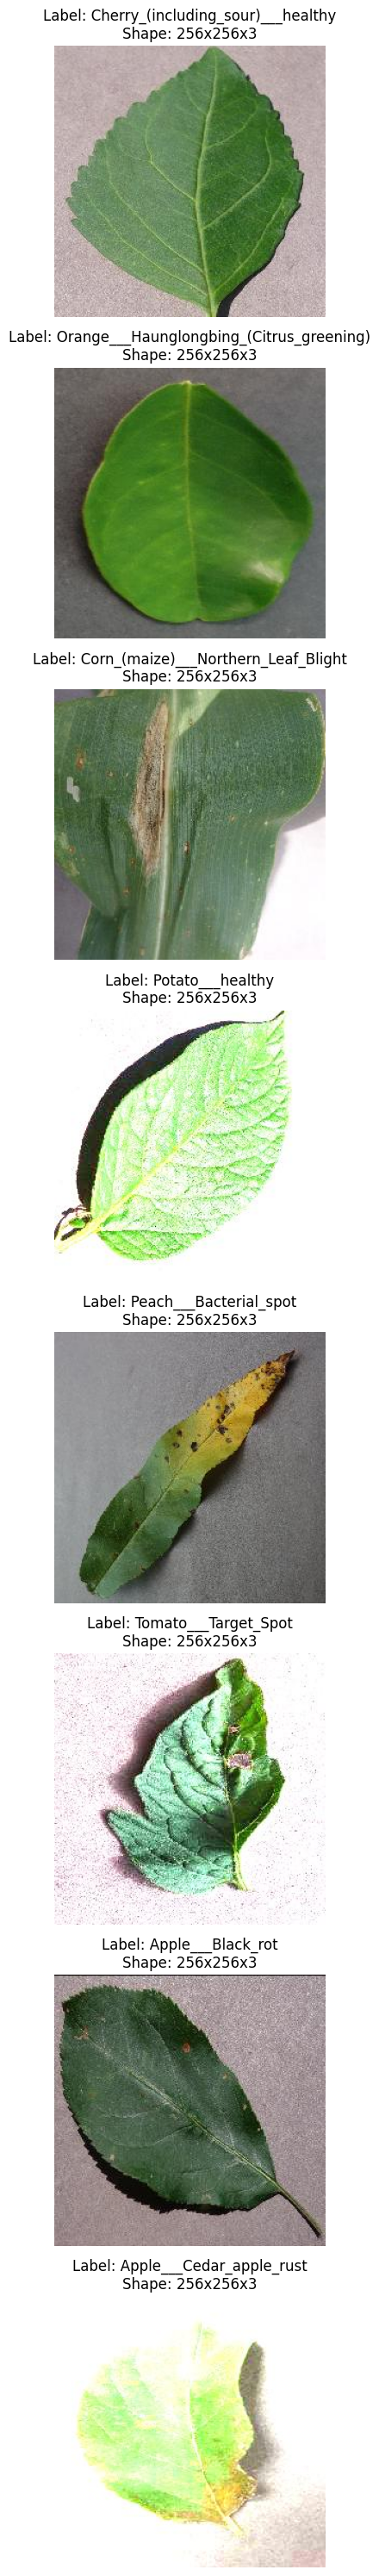

In [28]:
# display some images
random.seed(32)

# get all of the image paths
image_path_list = list(dataset_dir.glob("*/*/*.jpg"))

# choose 20 images paths randomly
random_image_paths = random.sample(image_path_list, 20)

# define the subplot
fig, axes = plt.subplots(nrows=8, figsize=(30, 30))

# display 20 images randomly
for i, ax in enumerate(axes.flat):
    random_image_path = random_image_paths[i] # get image path
    image_class = random_image_path.parent.stem # get image class from path name as label
    image = Image.open(random_image_path) # open image
    ax.imshow(image) # display image on subplot
    
    # add label and shape of image
    ax.set_title(f"Label: {image_class}\nShape: {image.height}x{image.width}x{3 if image.mode == 'RGB' else 1}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [29]:
# create data transformation based on ResNet50 model (ResNet50_Weights.IMAGENET1K_V2)
train_transform_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.RandomRotation(45), # augmentation: random rotation 45 degree
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    # do not augment in validation data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [30]:
# create data transformation based on EfficientNet V2 model (EfficientNet_V2_S_Weights.IMAGENET1K_V1)
train_transform_ev2 = transforms.Compose([
    transforms.Resize(size=384, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=384),
    transforms.RandomRotation(45), # augmentation: random rotation 45 degree
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_ev2 = transforms.Compose([
    transforms.Resize(size=384, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=384),
    # do not augment in validation data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [31]:
# create ImageFolder for prepare dataset
# this method is easier than custom dataset, because dataset has already split by folder train and validation

# ImageFolder for ResNet50 model
train_dataset_rn50 = datasets.ImageFolder(root=train_dir, transform=train_transform_rn50)
val_dataset_rn50 = datasets.ImageFolder(root=val_dir, transform=val_transform_rn50)

# ImageFolder for EfficientNet V2 model
train_dataset_ev2 = datasets.ImageFolder(root=train_dir, transform=train_transform_ev2)
val_dataset_ev2 = datasets.ImageFolder(root=val_dir, transform=val_transform_ev2)

# display classes of ImageFolder dataset
print(f"Dataset Classes: {len(train_dataset_ev2.classes)}\n")
train_dataset_ev2.classes

Dataset Classes: 38



['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [32]:
# create DataLoader for ResNet50 model
train_dataloader_rn50 = DataLoader(train_dataset_rn50,
                                   batch_size=32,
                                   num_workers=2,
                                   shuffle=True)

val_dataloader_rn50 = DataLoader(val_dataset_rn50,
                                 batch_size=32,
                                 num_workers=2,
                                 shuffle=False) # do not shuffle on validation data

# create DataLoader for EfficientNet V2 model
train_dataloader_ev2 = DataLoader(train_dataset_ev2,
                                  batch_size=32,
                                  num_workers=2,
                                  shuffle=True)

val_dataloader_ev2 = DataLoader(val_dataset_ev2,
                                batch_size=32,
                                num_workers=2,
                                shuffle=False) # do not shuffle on validation data


print(f"Number of Train Dataloader: {len(train_dataloader_ev2)} batches")
print(f"Number of Validation Dataloader: {len(val_dataloader_ev2)} batches")

Number of Train Dataloader: 4394 batches
Number of Validation Dataloader: 1099 batches


In [37]:
# looking information inside dataloader has made: ResNet50

# get the batch sample in the dataloader
# dataloader contains input and output (feature and label)
images, labels = next(iter(train_dataloader_rn50))

# get the number of batches in the dataloader
num_batches = len(train_dataloader_rn50)

# print out the summary
print("[DATALOADER FOR RESNET50 MODEL]\n")
print(f"Train Dataloader = {train_dataloader_rn50}\n")
print(f"Batch Sample:\nImage Shape = {images.shape}\nLabel Shape = {labels.shape}\nLabels = {labels.tolist()}")
print(f"Number of Batches = {num_batches} batches")
print(f"Number of All Data = {32*num_batches} images")


[DATALOADER FOR RESNET50 MODEL]

Train Dataloader = <torch.utils.data.dataloader.DataLoader object at 0x000001A7382E8E90>

Batch Sample:
Image Shape = torch.Size([32, 3, 224, 224])
Label Shape = torch.Size([32])
Labels = [17, 19, 19, 28, 25, 28, 6, 6, 2, 17, 36, 19, 36, 14, 30, 37, 16, 9, 17, 23, 32, 23, 14, 24, 19, 0, 17, 37, 6, 10, 13, 9]
Number of Batches = 4394 batches
Number of All Data = 140608 images


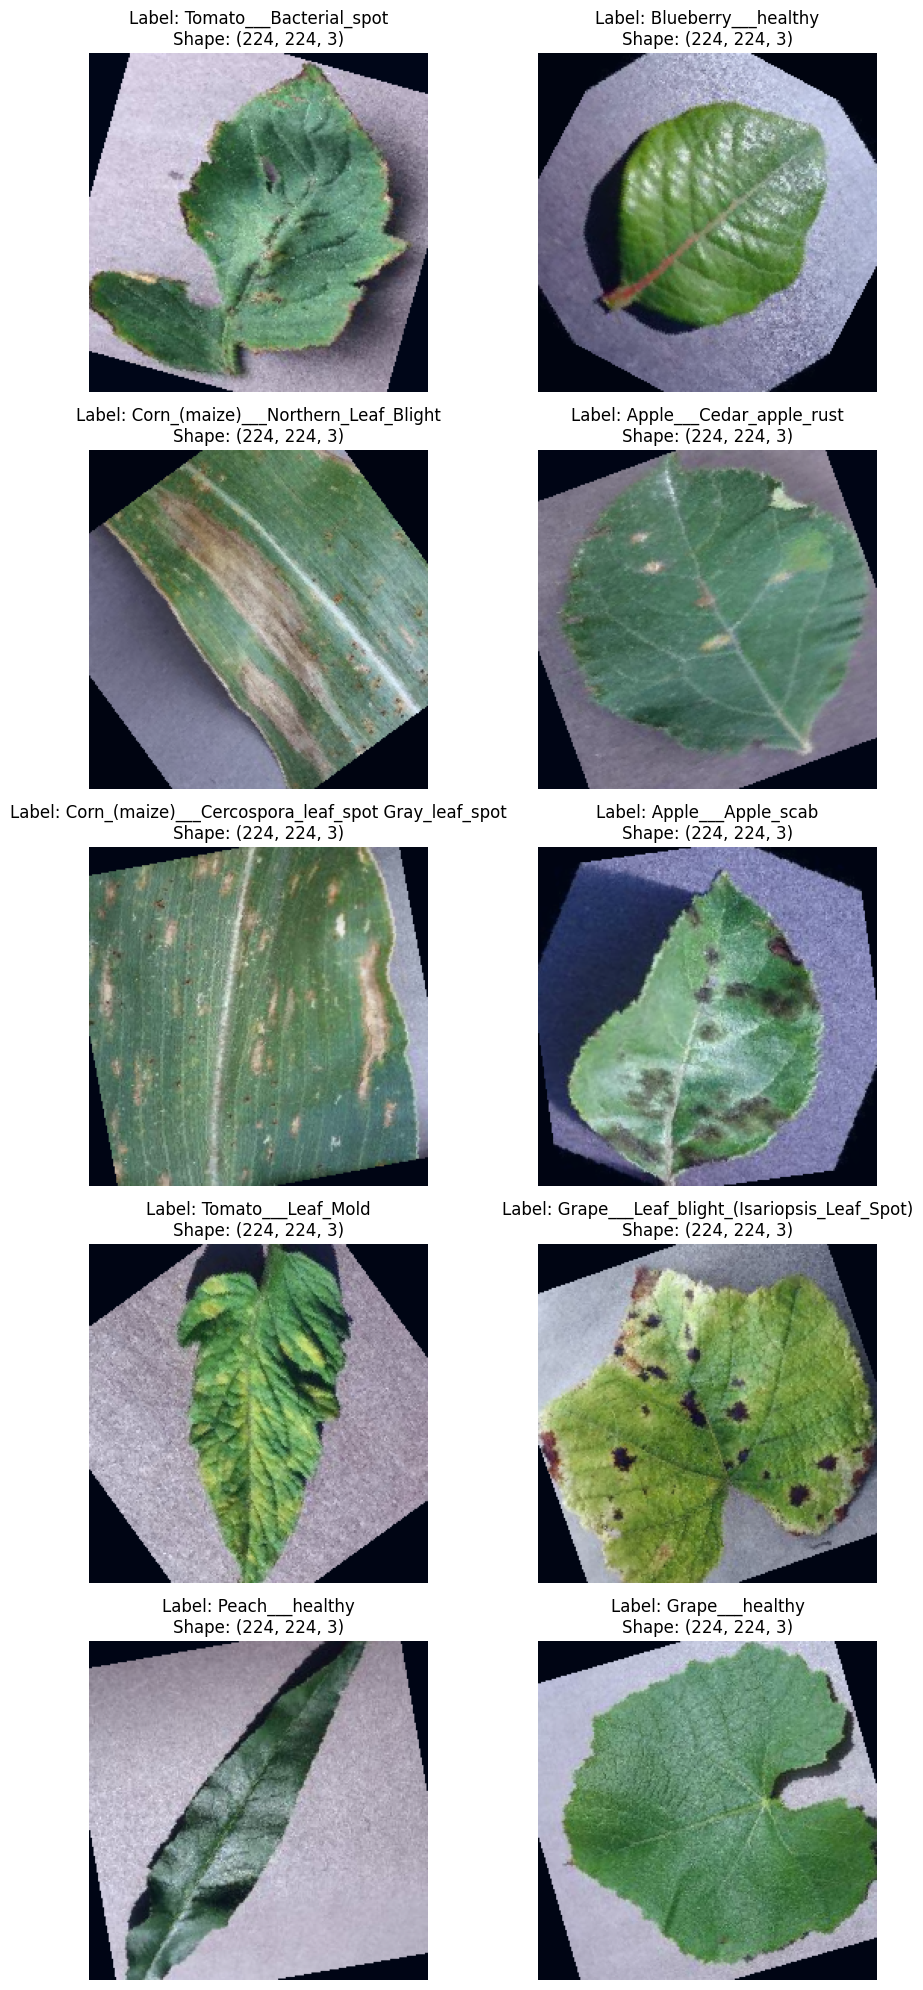

In [39]:
# visualize dataloader: ResNet50
torch.manual_seed(33)

# visualize the sample of train dataloader
batch_images, batch_labels = next(iter(train_dataloader_rn50))

# function for displaying 10 images randomly from dataloader
def display_images(images, labels, class_names, nrows=5, ncols=2):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 20))
    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) # normalization display to 0 - 1
        ax.imshow(img)
        # get class name from label
        label_idx = labels[i].item()
        class_name = class_names[label_idx]
        # display class name
        ax.set_title(f"Label: {class_name}\nShape: {img.shape}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# display images
display_images(batch_images, batch_labels, train_dataset_rn50.classes)

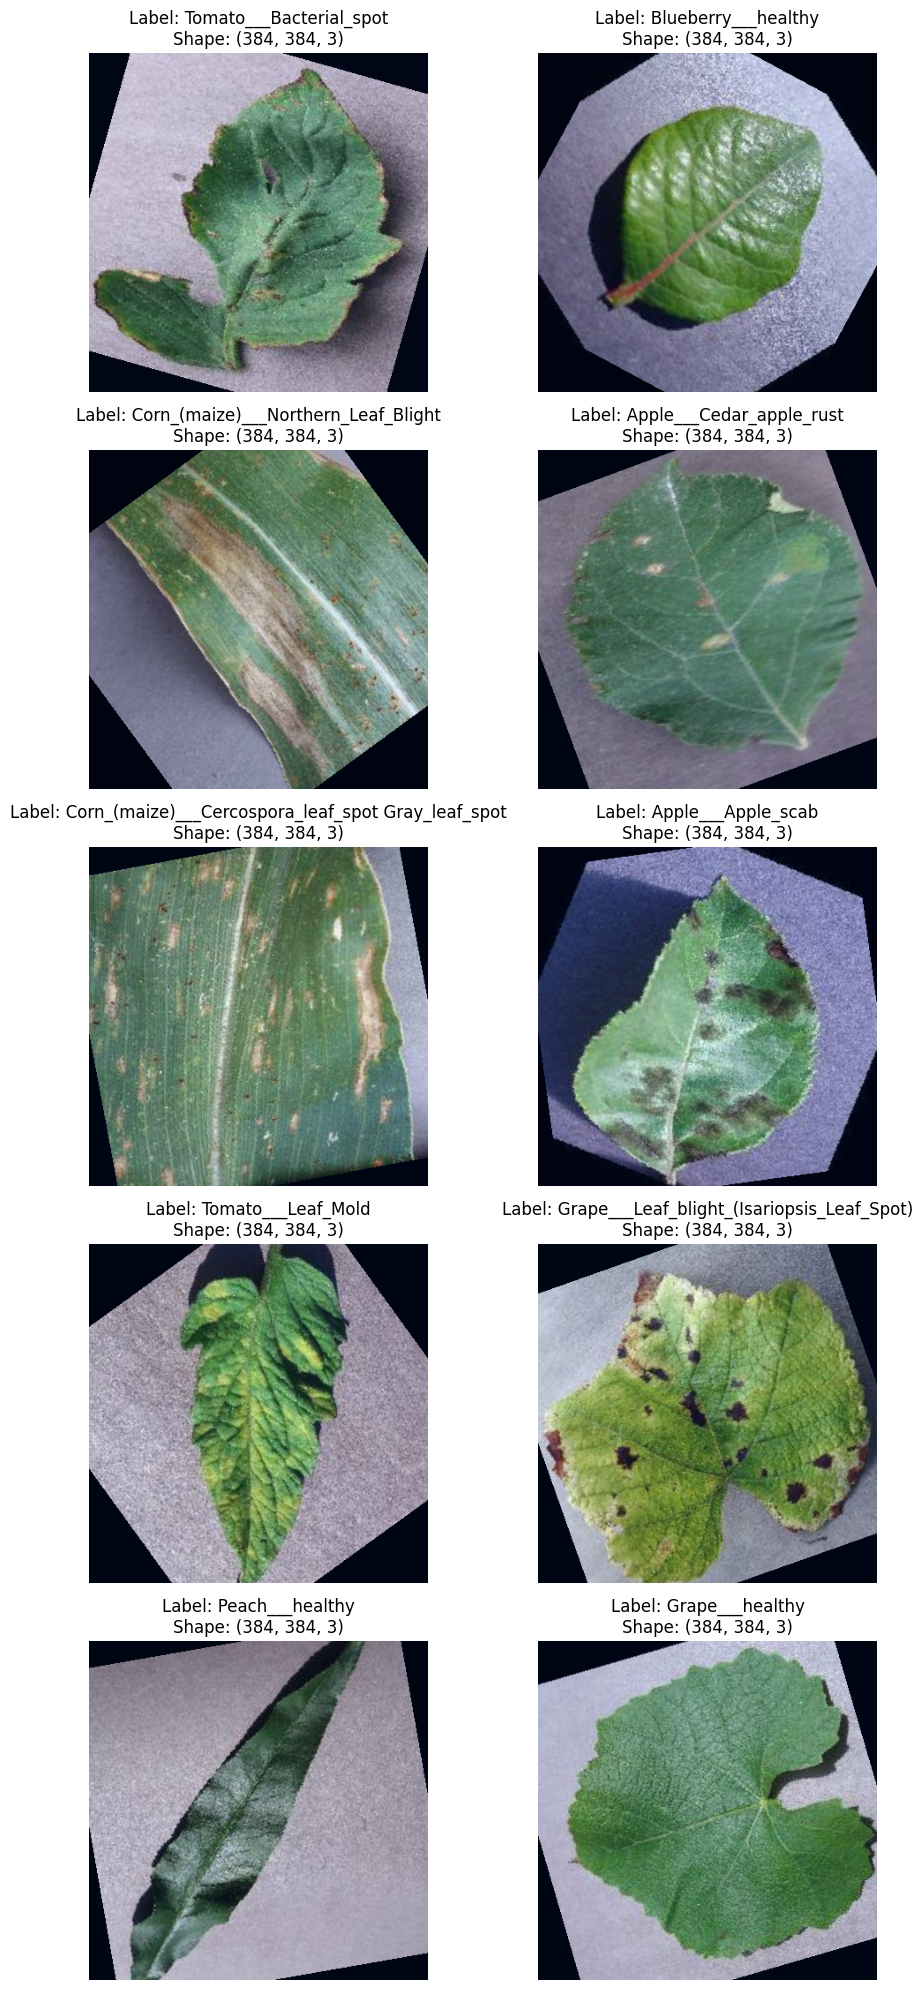

In [40]:
# visualize dataloader: EfficientNet V2
torch.manual_seed(33)

# visualize the sample of train dataloader
batch_images, batch_labels = next(iter(train_dataloader_ev2))

# function for displaying 10 images randomly from dataloader
def display_images(images, labels, class_names, nrows=5, ncols=2):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 20))
    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) # normalization display to 0 - 1
        ax.imshow(img)
        # get class name from label
        label_idx = labels[i].item()
        class_name = class_names[label_idx]
        # display class name
        ax.set_title(f"Label: {class_name}\nShape: {img.shape}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# display images
display_images(batch_images, batch_labels, train_dataset_ev2.classes)

In [42]:
# load pre-trained ResNet50 model: ResNet50_Weights.IMAGENET1K_V2
rn50_model = resnet50(weights=ResNet50_Weights.DEFAULT)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# modify fully connected layer
rn50_model.fc = nn.Sequential(nn.Linear(in_features=rn50_model.fc.in_features, out_features=38))

# freeze pre-trained layers
for param in rn50_model.parameters():
    param.requires_grad = False

# unfreeze fully connected layers
for param in rn50_model.fc.parameters():
    param.requires_grad = True

# put model into device
rn50_model = rn50_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Muhammad fahrian/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100.0%


In [46]:
# load pre-trained EfficientNet V2 model: EfficientNet_V2_S_Weights.IMAGENET1K_V1
ev2_model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

# modify fully connected layer
ev2_model.classifier = nn.Sequential(nn.Linear(in_features=1280, out_features=38))

# freeze pre-trained layers
for param in ev2_model.parameters():
    param.requires_grad = False

# unfreeze fully connected layers
for param in ev2_model.classifier.parameters():
    param.requires_grad = True

# put model into device
ev2_model = ev2_model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to C:\Users\Muhammad fahrian/.cache\torch\hub\checkpoints\efficientnet_v2_s-dd5fe13b.pth
100.0%


In [47]:
# train loop function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # put model in train mode
    model.train()

    # setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # send data to target device
        X, y = X.to(device), y.to(device)

        # 1. forward pass
        y_pred = model(X)

        # 2. calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # 6. calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [44]:
# use CrossEntropyLoss() for multiclass classification task
loss_fn = nn.CrossEntropyLoss()

In [48]:
# Adam optimizer
optim_rn50 = Adam(params=rn50_model.parameters(), lr=0.001)
optim_ev2 = Adam(params=ev2_model.parameters(), lr=0.001)

In [50]:
# train loop function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # put model in train mode
    model.train()

    # setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # send data to target device
        X, y = X.to(device), y.to(device)

        # 1. forward pass
        y_pred = model(X)

        # 2. calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # 6. calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [51]:
# validation loop test
def val_step(model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module):
    # put model in eval mode
    model.eval()

    # setup test loss and test accuracy values
    val_loss, val_acc = 0, 0

    # turn on inference context manager
    with torch.inference_mode():
        # loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # send data to target device
            X, y = X.to(device), y.to(device)

            # 1. forward pass
            val_pred_logits = model(X)

            # 2. calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # 3. calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [52]:
# train process

# 1. take in various parameters required for training and test steps
def train_process(model: torch.nn.Module,
                  train_dataloader: torch.utils.data.DataLoader,
                  val_dataloader: torch.utils.data.DataLoader,
                  optimizer: torch.optim.Optimizer,
                  loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
                  epochs: int = 5):

    # 2. create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    # 3. loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        val_loss, val_acc = val_step(model=model,
                                     dataloader=val_dataloader,
                                     loss_fn=loss_fn)

        # 4. print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # 5. update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    # 6. return the filled results at the end of the epochs
    return results

In [53]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
NUM_EPOCHS = 5

# start the timer
start_time = timer()

# train fine tuning ResNet50 model
rn50_results = train_process(model=rn50_model,
                             train_dataloader=train_dataloader_rn50,
                             val_dataloader=val_dataloader_rn50,
                             optimizer=optim_rn50,
                             loss_fn=loss_fn,
                             epochs=NUM_EPOCHS)

# end the timer and print out how long it took
end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [20:17<?, ?it/s]


KeyboardInterrupt: 